Loaded biomed: shape (1283,)
File mean_2.npy not found, skipping mean_2
Loaded mean_5: shape (1283,)
Loaded 5fold: shape (1283,)
File 3-bert_lstm.npy not found, skipping 3-bert_lstm
File predicted_risk_labels.npy not found, skipping predicted_risk_labels
File predicted_risk_labels1.npy not found, skipping predicted_risk_labels1

Predictions DataFrame shape: (1283, 3)
biomed: [535 502 186  60]
mean_5: [474 609 174  26]
5fold: [470 581 191  41]
        biomed  mean_5  5fold
biomed   1.000   0.648  0.642
mean_5   0.648   1.000  0.774
5fold    0.642   0.774  1.000


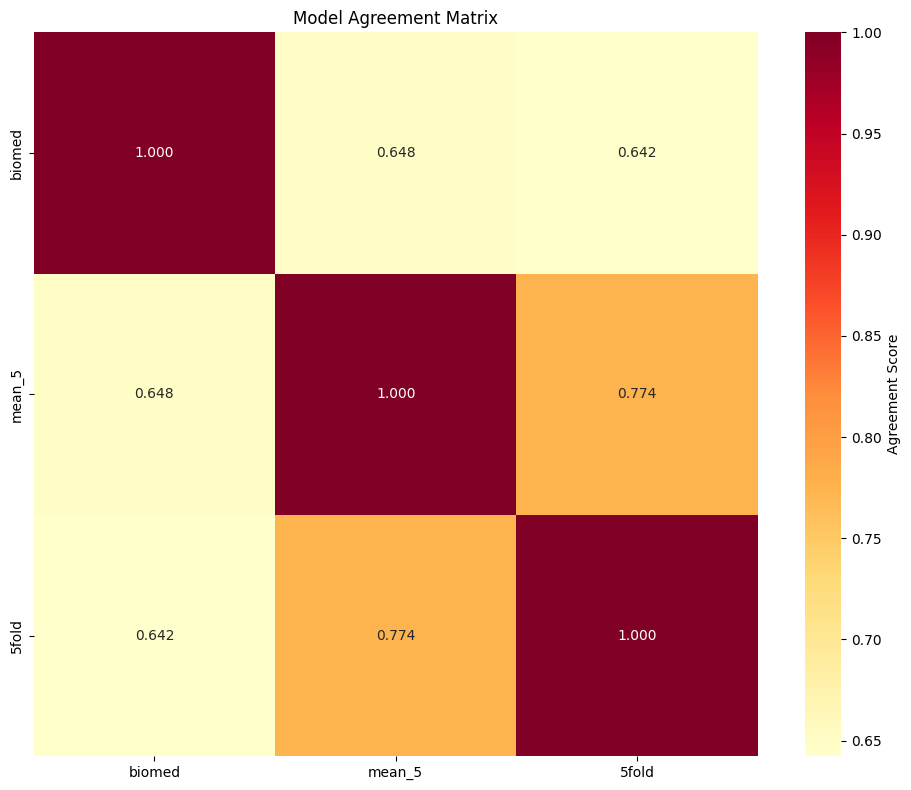

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

model_files = {
    'biomed': 'biomed.npy', 
    'mean_2': 'mean_2.npy',
    'mean_5': 'mean_5.npy',
    '5fold': '5fold.npy',
    '3-bert_lstm': '3-bert_lstm.npy',
    'predicted_risk_labels': 'predicted_risk_labels.npy',
    'predicted_risk_labels1': 'predicted_risk_labels1.npy'
}


# model_files = {
#     'biomed': 'biomed.npy',
#     'mean_5': 'mean_5.npy',
#     '5fold': '5fold.npy',
#     '5fold_bio': '5fold_bio.npy',
#     '3-bert_lstm': '3-bert_lstm.npy',
#     'predicted_risk_labels': 'predicted_risk_labels.npy',
#     'predicted_risk_labels1': 'predicted_risk_labels1.npy'
# }


predictions = {}
for name, file in model_files.items():
    try:
        predictions[name] = np.load(file)
        print(f"Loaded {name}: shape {predictions[name].shape}")
    except FileNotFoundError:
        print(f"File {file} not found, skipping {name}")

pred_df = pd.DataFrame(predictions)
print(f"\nPredictions DataFrame shape: {pred_df.shape}")


for col in pred_df.columns:
    class_counts = np.bincount(pred_df[col])
    print(f"{col}: {class_counts}")


def calculate_agreement_matrix(pred_df):
    models = pred_df.columns
    n_models = len(models)
    agreement_matrix = np.zeros((n_models, n_models))
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i == j:
                agreement_matrix[i, j] = 1.0
            else:
                agreement = (pred_df[model1] == pred_df[model2]).mean()
                agreement_matrix[i, j] = agreement
    
    return pd.DataFrame(agreement_matrix, index=models, columns=models)

agreement_matrix = calculate_agreement_matrix(pred_df)

print(agreement_matrix.round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap='YlOrRd', fmt='.3f', 
            square=True, cbar_kws={'label': 'Agreement Score'})
plt.title('Model Agreement Matrix')
plt.tight_layout()
plt.show()

In [2]:
def hard_voting_ensemble(pred_df, tie_breaker_model='mean_5'):
    """
    Hard voting ensemble method
    
    Parameters:
    pred_df: DataFrame containing all model predictions
    tie_breaker_model: str, reference model for resolving ties
    
    Returns:
    ensemble_predictions: array, ensemble prediction results
    """
    n_samples = len(pred_df)
    ensemble_predictions = np.zeros(n_samples, dtype=int)
    
    for idx in range(n_samples):
        sample_preds = pred_df.iloc[idx].values
        
        # Count votes for each class
        unique, counts = np.unique(sample_preds, return_counts=True)
        max_count = counts.max()
        
        # Find classes with the most votes
        most_voted_classes = unique[counts == max_count]
        
        if len(most_voted_classes) == 1:
            # Clear majority vote
            ensemble_predictions[idx] = most_voted_classes[0]
        else:
            # Tie situation, use tie_breaker_model result
            ensemble_predictions[idx] = pred_df.loc[idx, tie_breaker_model]
    
    return ensemble_predictions

# Execute hard voting
ensemble_preds = hard_voting_ensemble(pred_df, tie_breaker_model='mean_5')

# Statistics of ensemble results
print("=== Hard Voting Ensemble Results ===")
ensemble_class_counts = np.bincount(ensemble_preds)
print(f"Ensemble prediction class distribution: {ensemble_class_counts}")

# Analyze voting resolution
def analyze_voting_resolution(pred_df, ensemble_preds, tie_breaker_model='mean_5'):
    """Analyze detailed statistics of voting resolution"""
    n_samples = len(pred_df)
    majority_votes = 0  # Resolved by majority vote
    tie_breaker_used = 0  # Resolved using tie_breaker
    
    for idx in range(n_samples):
        sample_preds = pred_df.iloc[idx].values
        unique, counts = np.unique(sample_preds, return_counts=True)
        max_count = counts.max()
        most_voted_classes = unique[counts == max_count]
        
        if len(most_voted_classes) == 1:
            majority_votes += 1
        else:
            tie_breaker_used += 1
    
    print(f"\n=== Voting Resolution Statistics ===")
    print(f"Resolved by majority vote: {majority_votes} ({majority_votes/n_samples*100:.1f}%)")
    print(f"Resolved by {tie_breaker_model} for ties: {tie_breaker_used} ({tie_breaker_used/n_samples*100:.1f}%)")
    
    return majority_votes, tie_breaker_used

voting_resolution_stats = analyze_voting_resolution(pred_df, ensemble_preds, 'mean_5')

# Save ensemble results
np.save('ensemble_1.npy', ensemble_preds)
print(f"\nEnsemble prediction results saved to 'ensemble.npy'")

=== Hard Voting Ensemble Results ===
Ensemble prediction class distribution: [478 602 177  26]

=== Voting Resolution Statistics ===
Resolved by majority vote: 1227 (95.6%)
Resolved by mean_5 for ties: 56 (4.4%)

Ensemble prediction results saved to 'ensemble.npy'


In [3]:
# 4. Voting consistency analysis
def analyze_voting_consistency(pred_df):
    """Analyze voting consistency"""
    n_models = len(pred_df.columns)
    n_samples = len(pred_df)
    
    full_agreement = 0  # Full agreement
    one_disagree = 0    # Only one disagreement
    no_majority = 0     # Cannot resolve by voting (no majority consensus)
    
    for idx in range(n_samples):
        sample_preds = pred_df.iloc[idx].values
        unique, counts = np.unique(sample_preds, return_counts=True)
        max_count = counts.max()
        
        if max_count == n_models:
            # Full agreement
            full_agreement += 1
        elif max_count == n_models - 1:
            # Only one disagreement
            one_disagree += 1
        elif max_count <= n_models // 2:
            # No majority consensus
            no_majority += 1
    
    print(f"\n=== Voting Consistency Statistics ===")
    print(f"Total samples: {n_samples}")
    print(f"Full agreement: {full_agreement} ({full_agreement/n_samples*100:.1f}%)")
    print(f"Only one disagreement: {one_disagree} ({one_disagree/n_samples*100:.1f}%)")
    print(f"Cannot resolve by voting: {no_majority} ({no_majority/n_samples*100:.1f}%)")
    
    return full_agreement, one_disagree, no_majority

voting_stats = analyze_voting_consistency(pred_df)


=== Voting Consistency Statistics ===
Total samples: 1283
Full agreement: 711 (55.4%)
Only one disagreement: 516 (40.2%)
Cannot resolve by voting: 56 (4.4%)
